In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from keras.callbacks import Callback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Layer, GRU, Bidirectional, Dense, Input, Reshape, GlobalAveragePooling1D
import nltk
from nltk.corpus import wordnet
import random
from lime.lime_text import LimeTextExplainer

nltk.download('punkt')

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv(r"F:\MTL Cyberbullying\Cricket - Sheet1.csv")
df = df[['Text', 'Category', 'Polarity']]
df.head()

,Text,Category,Polarity
0,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,other,positive
1,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,team,positive
2,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,team,positive
3,সৌম্যকে বাদ দেওয়া হোক,batting,negative
4,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",team,positive


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize Bengali stopwords and lemmatizer
stop_words = set(stopwords.words('bengali'))
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
df.head()

,Text,Category,Polarity
0,জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...,other,positive
1,জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...,team,positive
2,বাংলাদেশের ভারতের সাপর্ট,team,positive
3,সৌম্যকে বাদ,batting,negative
4,প্রথমটি কোচ অতপর সাকিবসাকিব সাকিবরে দলে,team,positive


In [4]:
from sklearn.utils import resample

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())


Category distribution after upsampling:
Category
bowling            2799
batting            2226
team               2094
other              1913
team management    1468
Name: count, dtype: int64

Polarity distribution after upsampling:
Polarity
negative    3500
neutral     3500
positive    3500
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

In [8]:
# Tokenize the text using DistilBERT with padding and truncation
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='np')

df_upsampled['tokens'] = df_upsampled['Text'].apply(lambda x: tokenize_function(x))

# Train-test split
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [10]:
# Convert to TensorFlow Dataset
def create_tensor_dataset(df):
    # Tokenize input text and convert to TensorFlow tensors
    inputs = tokenizer(list(df['Text']), padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values)

    return tf.data.Dataset.from_tensor_slices(((input_ids, attention_mask), (labels_category, labels_polarity)))

In [11]:
# Create train and validation datasets
train_dataset = create_tensor_dataset(train_df)
val_dataset = create_tensor_dataset(val_df)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, GlobalAveragePooling1D
from tensorflow.keras import Model
from transformers import DistilBertTokenizer, TFDistilBertModel

In [13]:
# Initialize tokenizer and BERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize inputs
def tokenize_inputs(texts, max_length=128):
    inputs = tokenizer(
        texts, return_tensors="tf", padding="max_length",
        truncation=True, max_length=max_length
    )
    return inputs['input_ids'], inputs['attention_mask']

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [14]:
# GCN Layer
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.dense = Dense(units, use_bias=False)

    def call(self, features, adj_matrix):
        # Normalize the adjacency matrix
        adj_matrix = self.normalize_adjacency_matrix(adj_matrix)

        # Perform graph convolution: H' = A*X*W
        h = tf.matmul(adj_matrix, features)  # A*X
        h = self.dense(h)  # Apply weight matrix W

        # Apply the activation function
        if self.activation:
            h = tf.keras.activations.get(self.activation)(h)

        return h

    def normalize_adjacency_matrix(self, adj_matrix):
        """ Normalize adjacency matrix by adding self-loops and applying symmetric normalization """
        # Add self-loops (identity matrix)
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
    
        adj_matrix = adj_matrix + tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
    
        # Symmetric normalization: D^(-1/2) * A * D^(-1/2)
        degree_matrix = tf.reduce_sum(adj_matrix, axis=-1)
        degree_matrix_inv_sqrt = tf.pow(degree_matrix + 1e-6, -0.5)
        degree_matrix_inv_sqrt = tf.linalg.diag(degree_matrix_inv_sqrt)
    
        adj_matrix_normalized = tf.matmul(degree_matrix_inv_sqrt, adj_matrix)
        adj_matrix_normalized = tf.matmul(adj_matrix_normalized, degree_matrix_inv_sqrt)
    
        return adj_matrix_normalized

In [15]:
# Define GRU Fusion Layer
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        self.gru = GRU(units, return_sequences=True)

    def call(self, x):
        return self.gru(x)

In [16]:
# Hierarchical GNN with Task-Specific Heads
class HierarchicalGNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(HierarchicalGNN, self).__init__(**kwargs)
        self.shared_gcn = GCNLayer(units)
        self.task_specific_gcn = GCNLayer(units)
        self.pooling = GlobalAveragePooling1D()

    def call(self, features, adj_matrix):
        shared_features = self.shared_gcn(features, adj_matrix)
        task_specific_features = self.task_specific_gcn(shared_features, adj_matrix)
        return task_specific_features

In [ ]:
# MultiTask GNN Model with BERT
class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.distilbert = bert_model
        self.gru_fusion = GRUFusionLayer(gnn_units)

        # Multi-Head Attention Layer
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)

        # Pooling layers to reduce the sequence dimension
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Separate task-specific Dense layers for final outputs
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Projection layer to reduce BERT embedding dimensionality to match attention mechanism
        self.feature_adjustment_layer = Dense(128, activation='relu')

        # Hierarchical GNN layers for each task
        self.category_gnn = HierarchicalGNN(units=gnn_units)
        self.polarity_gnn = HierarchicalGNN(units=gnn_units)

        self.num_heads = num_heads

    def call(self, input_ids, attention_mask):
        # Pass through DistilBERT to get embeddings
        bert_output = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Project BERT embeddings to match the GNN units dimension
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Create dynamic adjacency matrix using multi-head attention
        adj_matrix = self.create_dynamic_adjacency_matrix_with_attention(adjusted_features)

        # GRU Fusion for Contextualized Embeddings
        fused_features = self.gru_fusion(adjusted_features)

        # Multi-Task GNN Heads
        category_features = self.category_gnn(fused_features, adj_matrix)
        polarity_features = self.polarity_gnn(fused_features, adj_matrix)

        # Pooling to collapse the sequence dimension
        category_features_pooled = self.category_pooling(category_features)
        polarity_features_pooled = self.polarity_pooling(polarity_features)

        # Final task-specific outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

    def create_dynamic_adjacency_matrix_with_attention(self, bert_embeddings):
        # Multi-Head Attention to create adjacency matrix
        attention_output = self.multi_head_attention(query=bert_embeddings, key=bert_embeddings, value=bert_embeddings)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)

        # identity matrix for self-loops
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
        identity_matrix = tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
        adj_matrix = adj_matrix + identity_matrix

        return adj_matrix

Define model inputs and instantiate the model

In [18]:
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

gnn_units = 64
category_output_size = 5  
polarity_output_size = 3 
num_heads = 4

multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size
)

# Build model
output_category, output_polarity = multi_task_gnn_model(input_ids, attention_mask)
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model (MultiTas  ((None, 5),         66647432    ['input_ids[0][0]',              
 kGNNModel)                      (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
Total params: 66,647,432
Trainable params: 66,647,432
Non-trainable params: 0
________________

In [19]:
history = model.fit(train_dataset.batch(16), epochs=20, validation_data=val_dataset.batch(16))

Epoch 1/20
473/473 [==============================] - 120s 206ms/step - loss: 2.4654 - multi_task_gnn_model_loss: 1.4526 - multi_task_gnn_model_1_loss: 1.0128 - multi_task_gnn_model_accuracy: 0.3849 - multi_task_gnn_model_1_accuracy: 0.4948 - val_loss: 2.0660 - val_multi_task_gnn_model_loss: 1.1861 - val_multi_task_gnn_model_1_loss: 0.8799 - val_multi_task_gnn_model_accuracy: 0.5774 - val_multi_task_gnn_model_1_accuracy: 0.6405
Epoch 2/20
473/473 [==============================] - 109s 231ms/step - loss: 1.8745 - multi_task_gnn_model_loss: 1.1082 - multi_task_gnn_model_1_loss: 0.7663 - multi_task_gnn_model_accuracy: 0.6142 - multi_task_gnn_model_1_accuracy: 0.7102 - val_loss: 1.4741 - val_multi_task_gnn_model_loss: 0.8797 - val_multi_task_gnn_model_1_loss: 0.5944 - val_multi_task_gnn_model_accuracy: 0.7274 - val_multi_task_gnn_model_1_accuracy: 0.8155
Epoch 3/20
473/473 [==============================] - 105s 221ms/step - loss: 1.3658 - multi_task_gnn_model_loss: 0.8518 - multi_task_gn

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [22]:
# Step 1: Make predictions on the test set
# Prepare the test dataset
test_dataset = create_tensor_dataset(test_df)

In [23]:
# Define your class labels
category_class_names = ["Class1", "Class2", "Class3", "Class4", "Class5"]
polarity_class_names = ["Positive", "Negative", "Neutral"]

# 1. Evaluate model accuracy on the test dataset
evaluation_results = model.evaluate(test_dataset.batch(16))
# The evaluation_results will contain a list with all returned metrics

# Print out the results
print(f"Total Loss: {evaluation_results[0]}")
print(f"Category Task Loss: {evaluation_results[1]}")
print(f"Polarity Task Loss: {evaluation_results[2]}")
print(f"Category Test Accuracy: {evaluation_results[3]}")
print(f"Polarity Test Accuracy: {evaluation_results[4]}")

132/132 [==============================] - 10s 74ms/step - loss: 0.3614 - multi_task_gnn_model_loss: 0.2679 - multi_task_gnn_model_1_loss: 0.0935 - multi_task_gnn_model_accuracy: 0.9148 - multi_task_gnn_model_1_accuracy: 0.9733
Total Loss: 0.36139288544654846
Category Task Loss: 0.2678961753845215
Polarity Task Loss: 0.09349687397480011
Category Test Accuracy: 0.9147619009017944
Polarity Test Accuracy: 0.9733333587646484


1/1 [==============================] - 0s 51ms/step
Category Classification Report:
              precision    recall  f1-score   support

      Class1       0.91      0.93      0.92       458
      Class2       0.93      0.94      0.93       583
      Class3       0.93      0.92      0.93       343
      Class4       0.88      0.82      0.85       406
      Class5       0.92      0.95      0.94       310

    accuracy                           0.91      2100
   macro avg       0.91      0.91      0.91      2100
weighted avg       0.91      0.91      0.91      2100

Polarity Classification Report:
              precision    recall  f1-score   support

    Positive       0.99      0.95      0.97       718
    Negative       0.96      1.00      0.98       689
     Neutral       0.97      0.97      0.97       693

    accuracy                           0.97      2100
   macro avg       0.97      0.97      0.97      2100
weighted avg       0.97      0.97      0.97      2100



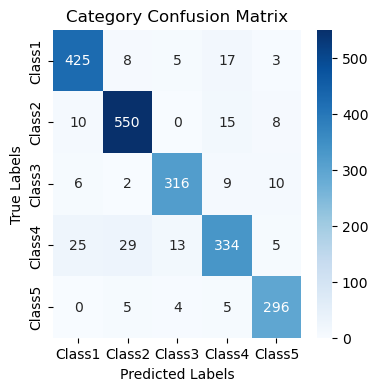

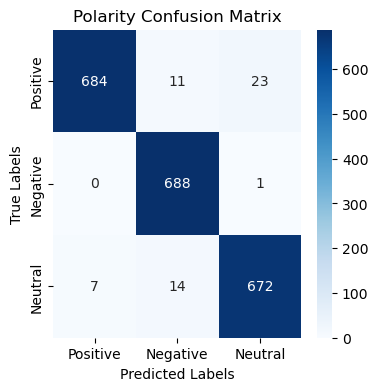

132/132 [==============================] - 11s 69ms/step


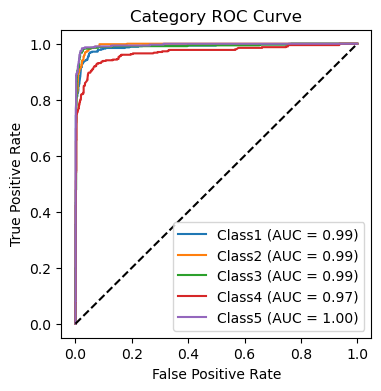

132/132 [==============================] - 9s 65ms/step


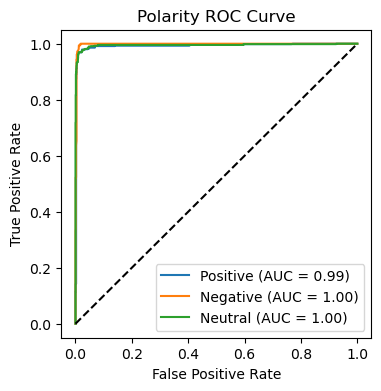

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get true labels and predictions for category and polarity tasks
true_category_labels = []
true_polarity_labels = []
pred_category_labels = []
pred_polarity_labels = []

for batch in test_dataset.batch(16):
    inputs, labels = batch
    input_ids, attention_mask = inputs  # Unpack the inputs tuple
    category_labels, polarity_labels = labels  # Unpack the labels tuple
    
    # Collect true labels
    true_category_labels.extend(category_labels.numpy())
    true_polarity_labels.extend(polarity_labels.numpy())
    
    # Get model predictions
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])
    pred_category_labels.extend(np.argmax(category_preds, axis=1))
    pred_polarity_labels.extend(np.argmax(polarity_preds, axis=1))


# Convert true labels and predictions to numpy arrays
true_category_labels = np.array(true_category_labels)
true_polarity_labels = np.array(true_polarity_labels)
pred_category_labels = np.array(pred_category_labels)
pred_polarity_labels = np.array(pred_polarity_labels)

# 2. Classification Report
print("Category Classification Report:")
print(classification_report(true_category_labels, pred_category_labels, target_names=category_class_names))

print("Polarity Classification Report:")
print(classification_report(true_polarity_labels, pred_polarity_labels, target_names=polarity_class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot confusion matrices for category and polarity tasks
plot_confusion_matrix(true_category_labels, pred_category_labels, category_class_names, "Category Confusion Matrix")
plot_confusion_matrix(true_polarity_labels, pred_polarity_labels, polarity_class_names, "Polarity Confusion Matrix")

# 4. ROC Curve (One-vs-Rest for multi-class)
def plot_roc_curve(true_labels, pred_probs, class_names, title):
    plt.figure(figsize=(4, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

# Category ROC Curve
category_pred_probs = model.predict(test_dataset.batch(16))[0]  # Probability predictions for category task
plot_roc_curve(true_category_labels, category_pred_probs, category_class_names, "Category ROC Curve")

# Polarity ROC Curve
polarity_pred_probs = model.predict(test_dataset.batch(16))[1]  # Probability predictions for polarity task
plot_roc_curve(true_polarity_labels, polarity_pred_probs, polarity_class_names, "Polarity ROC Curve")


In [29]:
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        # Set units to match the adjusted feature dimension (128)
        self.gru = GRU(128, return_sequences=True)

    def call(self, x):
        return self.gru(x)


In [ ]:
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        self.gru = GRU(128, return_sequences=True)

    def call(self, x):
        return self.gru(x)

# MultiTask GNN Model with BERT and Residual Connections
class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.distilbert = bert_model
        self.gru_fusion = GRUFusionLayer(gnn_units)

        # Multi-Head Attention Layer
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)

        # Pooling layers to reduce the sequence dimension
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Separate task-specific Dense layers for final outputs
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Projection layer to reduce BERT embedding dimensionality to match attention mechanism
        self.feature_adjustment_layer = Dense(128, activation='relu')

        # Hierarchical GNN layers for each task with residual connection support
        self.category_gnn = HierarchicalGNN(units=gnn_units)
        self.polarity_gnn = HierarchicalGNN(units=gnn_units)

        self.num_heads = num_heads

    def call(self, input_ids, attention_mask):
        # Pass through DistilBERT to get embeddings
        bert_output = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Project BERT embeddings to match the GNN units dimension
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Create dynamic adjacency matrix using multi-head attention
        adj_matrix = self.adjacency_matrix(adjusted_features)

        # GRU Fusion for Contextualized Embeddings
        fused_features = self.gru_fusion(adjusted_features)

        # Adding a residual connection between GRU output and original BERT embeddings
        fused_features_with_residual = fused_features + adjusted_features

        # Multi-Task GNN Heads with residual connections
        category_features = self.category_gnn(fused_features_with_residual, adj_matrix)
        category_features_with_residual = category_features + fused_features_with_residual

        polarity_features = self.polarity_gnn(fused_features_with_residual, adj_matrix)
        polarity_features_with_residual = polarity_features + fused_features_with_residual

        # Pooling to collapse the sequence dimension
        category_features_pooled = self.category_pooling(category_features_with_residual)
        polarity_features_pooled = self.polarity_pooling(polarity_features_with_residual)

        # Final task-specific outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

    def adjacency_matrix(self, bert_embeddings):
        # Multi-Head Attention to create adjacency matrix
        attention_output = self.multi_head_attention(query=bert_embeddings, key=bert_embeddings, value=bert_embeddings)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)

        # identity matrix for self-loops
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
        identity_matrix = tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
        adj_matrix = adj_matrix + identity_matrix

        return adj_matrix


In [34]:
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

gnn_units = 128
category_output_size = 5  
polarity_output_size = 3 
num_heads = 4

multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size
)

# Build model
output_category, output_polarity = multi_task_gnn_model(input_ids, attention_mask)
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model_4 (MultiT  ((None, 5),         66758920    ['input_ids[0][0]',              
 askGNNModel)                    (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
Total params: 66,758,920
Trainable params: 66,758,920
Non-trainable params: 0
______________

In [35]:
history = model.fit(train_dataset.batch(16), epochs=10, validation_data=val_dataset.batch(16))

Epoch 1/10
473/473 [==============================] - 104s 197ms/step - loss: 2.3262 - multi_task_gnn_model_4_loss: 1.3576 - multi_task_gnn_model_4_1_loss: 0.9686 - multi_task_gnn_model_4_accuracy: 0.4307 - multi_task_gnn_model_4_1_accuracy: 0.5155 - val_loss: 1.6554 - val_multi_task_gnn_model_4_loss: 0.9205 - val_multi_task_gnn_model_4_1_loss: 0.7349 - val_multi_task_gnn_model_4_accuracy: 0.6667 - val_multi_task_gnn_model_4_1_accuracy: 0.6893
Epoch 2/10
473/473 [==============================] - 91s 192ms/step - loss: 1.4222 - multi_task_gnn_model_4_loss: 0.8191 - multi_task_gnn_model_4_1_loss: 0.6031 - multi_task_gnn_model_4_accuracy: 0.7095 - multi_task_gnn_model_4_1_accuracy: 0.7562 - val_loss: 0.9742 - val_multi_task_gnn_model_4_loss: 0.5613 - val_multi_task_gnn_model_4_1_loss: 0.4129 - val_multi_task_gnn_model_4_accuracy: 0.8048 - val_multi_task_gnn_model_4_1_accuracy: 0.8440
Epoch 3/10
473/473 [==============================] - 91s 193ms/step - loss: 0.8753 - multi_task_gnn_mode

In [36]:
# Define your class labels
category_class_names = ["Class1", "Class2", "Class3", "Class4", "Class5"]
polarity_class_names = ["Positive", "Negative", "Neutral"]

# 1. Evaluate model accuracy on the test dataset
evaluation_results = model.evaluate(test_dataset.batch(16))
# The evaluation_results will contain a list with all returned metrics

# Print out the results
print(f"Total Loss: {evaluation_results[0]}")
print(f"Category Task Loss: {evaluation_results[1]}")
print(f"Polarity Task Loss: {evaluation_results[2]}")
print(f"Category Test Accuracy: {evaluation_results[3]}")
print(f"Polarity Test Accuracy: {evaluation_results[4]}")

132/132 [==============================] - 9s 70ms/step - loss: 0.4225 - multi_task_gnn_model_4_loss: 0.2956 - multi_task_gnn_model_4_1_loss: 0.1268 - multi_task_gnn_model_4_accuracy: 0.9181 - multi_task_gnn_model_4_1_accuracy: 0.9624
Total Loss: 0.42245474457740784
Category Task Loss: 0.2956145703792572
Polarity Task Loss: 0.12684029340744019
Category Test Accuracy: 0.9180952310562134
Polarity Test Accuracy: 0.9623809456825256


1/1 [==============================] - 0s 48ms/step
Category Classification Report:
              precision    recall  f1-score   support

      Class1       0.91      0.92      0.92       458
      Class2       0.94      0.95      0.94       583
      Class3       0.88      0.96      0.92       343
      Class4       0.92      0.81      0.86       406
      Class5       0.93      0.96      0.94       310

    accuracy                           0.92      2100
   macro avg       0.92      0.92      0.92      2100
weighted avg       0.92      0.92      0.92      2100

Polarity Classification Report:
              precision    recall  f1-score   support

    Positive       0.98      0.94      0.96       718
    Negative       0.95      0.99      0.97       689
     Neutral       0.96      0.95      0.96       693

    accuracy                           0.96      2100
   macro avg       0.96      0.96      0.96      2100
weighted avg       0.96      0.96      0.96      2100



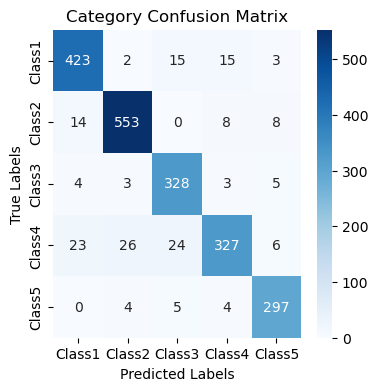

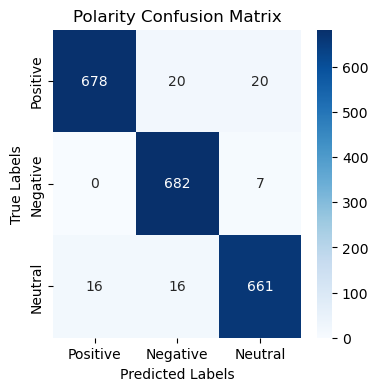

132/132 [==============================] - 14s 76ms/step


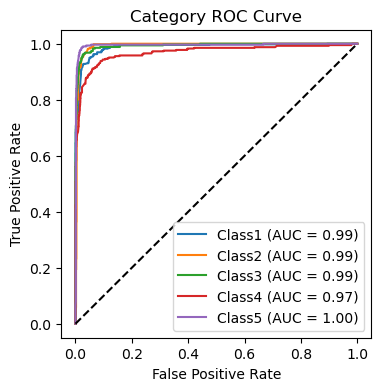

132/132 [==============================] - 10s 78ms/step


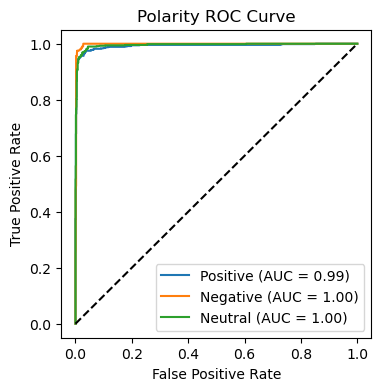

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get true labels and predictions for category and polarity tasks
true_category_labels = []
true_polarity_labels = []
pred_category_labels = []
pred_polarity_labels = []

for batch in test_dataset.batch(16):
    inputs, labels = batch
    input_ids, attention_mask = inputs  # Unpack the inputs tuple
    category_labels, polarity_labels = labels  # Unpack the labels tuple
    
    # Collect true labels
    true_category_labels.extend(category_labels.numpy())
    true_polarity_labels.extend(polarity_labels.numpy())
    
    # Get model predictions
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])
    pred_category_labels.extend(np.argmax(category_preds, axis=1))
    pred_polarity_labels.extend(np.argmax(polarity_preds, axis=1))


# Convert true labels and predictions to numpy arrays
true_category_labels = np.array(true_category_labels)
true_polarity_labels = np.array(true_polarity_labels)
pred_category_labels = np.array(pred_category_labels)
pred_polarity_labels = np.array(pred_polarity_labels)

# 2. Classification Report
print("Category Classification Report:")
print(classification_report(true_category_labels, pred_category_labels, target_names=category_class_names))

print("Polarity Classification Report:")
print(classification_report(true_polarity_labels, pred_polarity_labels, target_names=polarity_class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot confusion matrices for category and polarity tasks
plot_confusion_matrix(true_category_labels, pred_category_labels, category_class_names, "Category Confusion Matrix")
plot_confusion_matrix(true_polarity_labels, pred_polarity_labels, polarity_class_names, "Polarity Confusion Matrix")

# 4. ROC Curve (One-vs-Rest for multi-class)
def plot_roc_curve(true_labels, pred_probs, class_names, title):
    plt.figure(figsize=(4, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

# Category ROC Curve
category_pred_probs = model.predict(test_dataset.batch(16))[0]  # Probability predictions for category task
plot_roc_curve(true_category_labels, category_pred_probs, category_class_names, "Category ROC Curve")

# Polarity ROC Curve
polarity_pred_probs = model.predict(test_dataset.batch(16))[1]  # Probability predictions for polarity task
plot_roc_curve(true_polarity_labels, polarity_pred_probs, polarity_class_names, "Polarity ROC Curve")


In [ ]:
# GCN Layer with Residual Connections
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.dense = Dense(units, use_bias=False)

    def call(self, features, adj_matrix):
        # Normalize the adjacency matrix
        adj_matrix = self.normalize_adjacency_matrix(adj_matrix)

        # Perform graph convolution: H' = A*X*W
        h = tf.matmul(adj_matrix, features)  # A*X
        h = self.dense(h)  # Apply weight matrix W

        # Apply the activation function
        if self.activation:
            h = tf.keras.activations.get(self.activation)(h)

        # Add residual connection: Output = H + features (node-to-node residual)
        h = h + features

        return h

    def normalize_adjacency_matrix(self, adj_matrix):
        """ Normalize adjacency matrix by adding self-loops and applying symmetric normalization """
        # Add self-loops (identity matrix)
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
    
        adj_matrix = adj_matrix + tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
    
        # Symmetric normalization: D^(-1/2) * A * D^(-1/2)
        degree_matrix = tf.reduce_sum(adj_matrix, axis=-1)
        degree_matrix_inv_sqrt = tf.pow(degree_matrix + 1e-6, -0.5)
        degree_matrix_inv_sqrt = tf.linalg.diag(degree_matrix_inv_sqrt)
    
        adj_matrix_normalized = tf.matmul(degree_matrix_inv_sqrt, adj_matrix)
        adj_matrix_normalized = tf.matmul(adj_matrix_normalized, degree_matrix_inv_sqrt)
    
        return adj_matrix_normalized

# Hierarchical GNN with Task-Specific Heads
class HierarchicalGNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(HierarchicalGNN, self).__init__(**kwargs)
        self.shared_gcn = GCNLayer(units)
        self.task_specific_gcn = GCNLayer(units)
        self.pooling = GlobalAveragePooling1D()

    def call(self, features, adj_matrix):
        shared_features = self.shared_gcn(features, adj_matrix)
        task_specific_features = self.task_specific_gcn(shared_features, adj_matrix)
        return task_specific_features
    
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        # Ensure GRU output matches adjusted features dimension (128)
        self.gru = GRU(128, return_sequences=True)

    def call(self, x):
        return self.gru(x)

# MultiTask GNN Model with BERT and Residual Connections
class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.distilbert = bert_model
        self.gru_fusion = GRUFusionLayer(gnn_units)

        # Multi-Head Attention Layer
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)

        # Pooling layers to reduce the sequence dimension
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Separate task-specific Dense layers for final outputs
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Projection layer to reduce BERT embedding dimensionality to match attention mechanism
        self.feature_adjustment_layer = Dense(128, activation='relu')

        # Hierarchical GNN layers for each task with residual connection support
        self.category_gnn = HierarchicalGNN(units=gnn_units)
        self.polarity_gnn = HierarchicalGNN(units=gnn_units)

        self.num_heads = num_heads

    def call(self, input_ids, attention_mask):
        # Pass through DistilBERT to get embeddings
        bert_output = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Project BERT embeddings to match the GNN units dimension
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Create dynamic adjacency matrix using multi-head attention
        adj_matrix = self.adjacency_matrix(adjusted_features)

        # GRU Fusion for Contextualized Embeddings
        fused_features = self.gru_fusion(adjusted_features)

        # Adding a residual connection between GRU output and original BERT embeddings
        fused_features_with_residual = fused_features + adjusted_features

        # Multi-Task GNN Heads with residual connections
        category_features = self.category_gnn(fused_features_with_residual, adj_matrix)
        category_features_with_residual = category_features + fused_features_with_residual

        polarity_features = self.polarity_gnn(fused_features_with_residual, adj_matrix)
        polarity_features_with_residual = polarity_features + fused_features_with_residual

        # Pooling to collapse the sequence dimension
        category_features_pooled = self.category_pooling(category_features_with_residual)
        polarity_features_pooled = self.polarity_pooling(polarity_features_with_residual)

        # Final task-specific outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

    def adjacency_matrix(self, bert_embeddings):
        # Multi-Head Attention to create adjacency matrix
        attention_output = self.multi_head_attention(query=bert_embeddings, key=bert_embeddings, value=bert_embeddings)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)

        # identity matrix for self-loops
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
        identity_matrix = tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
        adj_matrix = adj_matrix + identity_matrix

        return adj_matrix

In [39]:
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

gnn_units = 128
category_output_size = 5  
polarity_output_size = 3 
num_heads = 4

multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size
)

# Build model
output_category, output_polarity = multi_task_gnn_model(input_ids, attention_mask)
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model_5 (MultiT  ((None, 5),         66758920    ['input_ids[0][0]',              
 askGNNModel)                    (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
Total params: 66,758,920
Trainable params: 66,758,920
Non-trainable params: 0
______________

In [40]:
history = model.fit(train_dataset.batch(16), epochs=10, validation_data=val_dataset.batch(16))

Epoch 1/10
473/473 [==============================] - 104s 199ms/step - loss: 0.7692 - multi_task_gnn_model_5_loss: 0.4654 - multi_task_gnn_model_5_1_loss: 0.3038 - multi_task_gnn_model_5_accuracy: 0.8384 - multi_task_gnn_model_5_1_accuracy: 0.8993 - val_loss: 0.4706 - val_multi_task_gnn_model_5_loss: 0.3231 - val_multi_task_gnn_model_5_1_loss: 0.1475 - val_multi_task_gnn_model_5_accuracy: 0.8952 - val_multi_task_gnn_model_5_1_accuracy: 0.9607
Epoch 2/10
473/473 [==============================] - 91s 192ms/step - loss: 0.2987 - multi_task_gnn_model_5_loss: 0.2147 - multi_task_gnn_model_5_1_loss: 0.0840 - multi_task_gnn_model_5_accuracy: 0.9290 - multi_task_gnn_model_5_1_accuracy: 0.9770 - val_loss: 0.4408 - val_multi_task_gnn_model_5_loss: 0.3091 - val_multi_task_gnn_model_5_1_loss: 0.1317 - val_multi_task_gnn_model_5_accuracy: 0.9083 - val_multi_task_gnn_model_5_1_accuracy: 0.9679
Epoch 3/10
473/473 [==============================] - 91s 192ms/step - loss: 0.2550 - multi_task_gnn_mode

In [41]:
# Define your class labels
category_class_names = ["Class1", "Class2", "Class3", "Class4", "Class5"]
polarity_class_names = ["Positive", "Negative", "Neutral"]

# 1. Evaluate model accuracy on the test dataset
evaluation_results = model.evaluate(test_dataset.batch(16))
# The evaluation_results will contain a list with all returned metrics

# Print out the results
print(f"Total Loss: {evaluation_results[0]}")
print(f"Category Task Loss: {evaluation_results[1]}")
print(f"Polarity Task Loss: {evaluation_results[2]}")
print(f"Category Test Accuracy: {evaluation_results[3]}")
print(f"Polarity Test Accuracy: {evaluation_results[4]}")

132/132 [==============================] - 9s 64ms/step - loss: 0.4666 - multi_task_gnn_model_5_loss: 0.3322 - multi_task_gnn_model_5_1_loss: 0.1344 - multi_task_gnn_model_5_accuracy: 0.9176 - multi_task_gnn_model_5_1_accuracy: 0.9648
Total Loss: 0.4665899872779846
Category Task Loss: 0.33219391107559204
Polarity Task Loss: 0.13439606130123138
Category Test Accuracy: 0.9176190495491028
Polarity Test Accuracy: 0.9647619128227234


1/1 [==============================] - 0s 47ms/step
Category Classification Report:
              precision    recall  f1-score   support

      Class1       0.91      0.93      0.92       458
      Class2       0.94      0.95      0.94       583
      Class3       0.90      0.94      0.92       343
      Class4       0.90      0.82      0.86       406
      Class5       0.94      0.95      0.95       310

    accuracy                           0.92      2100
   macro avg       0.92      0.92      0.92      2100
weighted avg       0.92      0.92      0.92      2100

Polarity Classification Report:
              precision    recall  f1-score   support

    Positive       0.97      0.96      0.97       718
    Negative       0.97      0.98      0.98       689
     Neutral       0.95      0.96      0.95       693

    accuracy                           0.96      2100
   macro avg       0.96      0.96      0.96      2100
weighted avg       0.96      0.96      0.96      2100



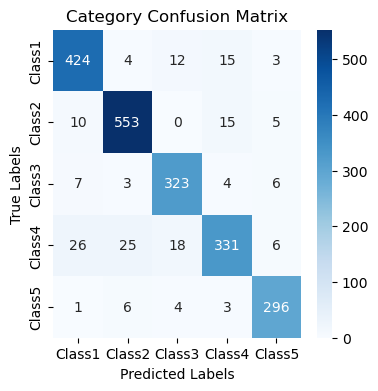

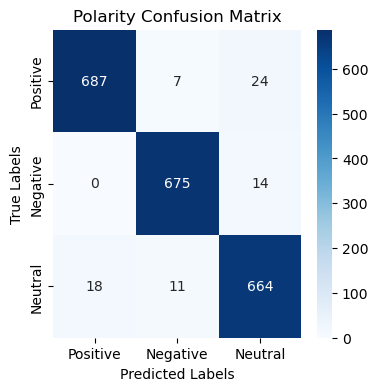

132/132 [==============================] - 13s 78ms/step


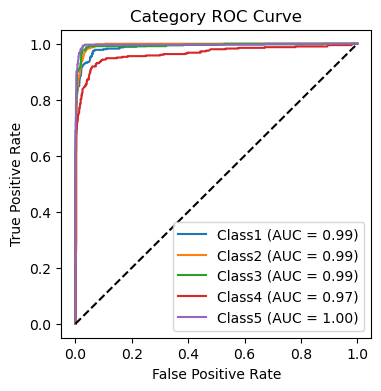

132/132 [==============================] - 10s 78ms/step


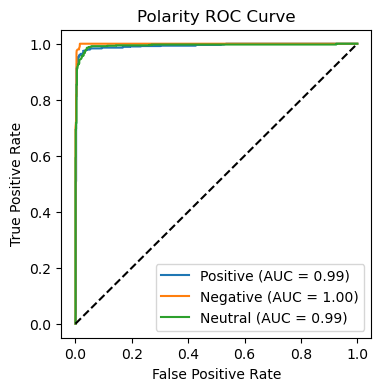

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get true labels and predictions for category and polarity tasks
true_category_labels = []
true_polarity_labels = []
pred_category_labels = []
pred_polarity_labels = []

for batch in test_dataset.batch(16):
    inputs, labels = batch
    input_ids, attention_mask = inputs  # Unpack the inputs tuple
    category_labels, polarity_labels = labels  # Unpack the labels tuple
    
    # Collect true labels
    true_category_labels.extend(category_labels.numpy())
    true_polarity_labels.extend(polarity_labels.numpy())
    
    # Get model predictions
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])
    pred_category_labels.extend(np.argmax(category_preds, axis=1))
    pred_polarity_labels.extend(np.argmax(polarity_preds, axis=1))


# Convert true labels and predictions to numpy arrays
true_category_labels = np.array(true_category_labels)
true_polarity_labels = np.array(true_polarity_labels)
pred_category_labels = np.array(pred_category_labels)
pred_polarity_labels = np.array(pred_polarity_labels)

# 2. Classification Report
print("Category Classification Report:")
print(classification_report(true_category_labels, pred_category_labels, target_names=category_class_names))

print("Polarity Classification Report:")
print(classification_report(true_polarity_labels, pred_polarity_labels, target_names=polarity_class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot confusion matrices for category and polarity tasks
plot_confusion_matrix(true_category_labels, pred_category_labels, category_class_names, "Category Confusion Matrix")
plot_confusion_matrix(true_polarity_labels, pred_polarity_labels, polarity_class_names, "Polarity Confusion Matrix")

# 4. ROC Curve (One-vs-Rest for multi-class)
def plot_roc_curve(true_labels, pred_probs, class_names, title):
    plt.figure(figsize=(4, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

# Category ROC Curve
category_pred_probs = model.predict(test_dataset.batch(16))[0]  # Probability predictions for category task
plot_roc_curve(true_category_labels, category_pred_probs, category_class_names, "Category ROC Curve")

# Polarity ROC Curve
polarity_pred_probs = model.predict(test_dataset.batch(16))[1]  # Probability predictions for polarity task
plot_roc_curve(true_polarity_labels, polarity_pred_probs, polarity_class_names, "Polarity ROC Curve")
